###Phase Leader plan:

Week 1: John (complete)

Week 2: Mike (complete)

Week 3: Steve (complete)

Week 4: Florencia


###Credit Assignment Plan Week 4:

Steve: Project management; final paper; analysis of results; pagerank; 

Florencia: SMOTE; pipeline creation; final paper

John: final paper; pagerank; feature eng

Mike: Neural Network, XGBoost, Gradient Boost models, and final paper;

In [0]:
#imports and paths
!pip install sparkxgb

# General Packages:
import numpy as np
import pandas as pd
import time
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import date, timedelta
from pyspark.sql.functions import col, isnan, when, mean,avg, stddev, count, sum, countDistinct, min, round, max, year, asc
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from collections import namedtuple

# For Pipeline
from pyspark.ml import Transformer
from pyspark.sql import DataFrame, Row
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct

# For Feature Engineering
from pyspark.ml.feature import VectorAssembler,MinMaxScaler,BucketedRandomProjectionLSH,VectorSlicer,IndexToString
from pyspark.sql.types import FloatType, IntegerType, TimestampType, StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import col, to_timestamp, hour, concat, date_format, rand, when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql.window import Window
from graphframes import GraphFrame

# For Modeling:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, MultilayerPerceptronClassifier, GBTClassifier
from sklearn.ensemble import AdaBoostClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
from sparkxgb import XGBoostClassifier
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import random

#dbutils.fs.help()
data_BASE_DIR = "/mnt/"
#display(dbutils.fs.ls(f"{data_BASE_DIR}"))


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [0]:
# spark.conf.set( "spark.serializer", 
#      "org.apache.spark.serializer.KyroSerializer")
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MyApp").config("spark.serializer", "org.apache.spark.serializer.JavaSerializer").getOrCreate()


In [0]:
blob_container  = "w261-container"
storage_account = "whiskeythedog"
secret_scope    = "whiskeythedog-scope"                   
secret_key      = "whikeythedog-key"  
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# Inspect the Mount's Final Project folder 
# Please IGNORE dbutils.fs.cp("/mnt/mids-w261/datasets_final_project/stations_data/", "/mnt/mids-w261/datasets_final_project_2022/stations_data/", recurse=True)
mids261_mount_path = "dbfs:/mnt/mids-w261/" #no permission to write to this mounted blob storage; 
display(dbutils.fs.ls(f"{mids261_mount_path}")) #3M, 12M, 36M, 60M

path,name,size,modificationTime
dbfs:/mnt/mids-w261/HW5/,HW5/,0,0
dbfs:/mnt/mids-w261/OTPW_12M/,OTPW_12M/,0,0
dbfs:/mnt/mids-w261/OTPW_1D_CSV/,OTPW_1D_CSV/,0,0
dbfs:/mnt/mids-w261/OTPW_36M/,OTPW_36M/,0,0
dbfs:/mnt/mids-w261/OTPW_3M/,OTPW_3M/,0,0
dbfs:/mnt/mids-w261/OTPW_3M_2015.csv,OTPW_3M_2015.csv,1500620247,1679772070000
dbfs:/mnt/mids-w261/OTPW_60M/,OTPW_60M/,0,0
dbfs:/mnt/mids-w261/airport-codes_csv.csv,airport-codes_csv.csv,6232459,1677623514000
dbfs:/mnt/mids-w261/datasets_final_project/,datasets_final_project/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/,datasets_final_project_2022/,0,0


In [0]:
# Inspect the Mount's Final Project folder 
# Please IGNORE dbutils.fs.cp("/mnt/mids-w261/datasets_final_project/stations_data/", "/mnt/mids-w261/datasets_final_project_2022/stations_data/", recurse=True)
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))
#display(dbutils.fs.ls(f"{data_BASE_DIR}stations_data/"))

path,name,size,modificationTime
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/,parquet_airlines_data/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/,parquet_airlines_data_1y/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/,parquet_airlines_data_3m/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_6m/,parquet_airlines_data_6m/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/,parquet_weather_data/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/,parquet_weather_data_1y/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/,parquet_weather_data_3m/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_6m/,parquet_weather_data_6m/,0,0
dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/,stations_data/,0,0


# Data Ingestion - 60M Dataset

In [0]:
# OTPW_60m = spark.read.parquet(f"{blob_url}pagerank/pagerank_60m/") # load raw data
OTPW_60M_gf = spark.read.parquet(f"{blob_url}/pipeline_train_js/")    # raw data with graph features added (_gf)

In [0]:
OTPW_60M_gf.count()

31673119

In [0]:
len(OTPW_60M_gf.columns)

217

# EDA <-- here is the main section for this part -->

In [0]:
def get_mode(df, column_name):
    mode_value = df.groupBy(column_name).count().orderBy(F.desc('count')).limit(1).collect()[0][0]
    return mode_value

# handle column and do imputation
def summarize_column(df, column_name, outcome_col, sample_rate=1, to_show=True, seed=42):
    df = df if sample_rate==1 else df.sample(False, sample_rate, seed)
    # cast the specific column to float
    df_with_cast = df.withColumn(column_name, col(column_name).cast('float'))
    df_filtered = df_with_cast.filter(col(column_name).isNotNull())
    
    # determine flags for different conditions
    df_with_flags = df_with_cast.withColumn('is_null_or_nan', col(column_name).isNull() | isnan(col(column_name)))
    df_with_flags = df_with_flags.withColumn('is_string_nan_or_null', col(column_name).isin('nan', 'null'))
    df_with_flags = df_with_flags.withColumn('is_float_castable', ~col('is_null_or_nan') & ~col('is_string_nan_or_null'))

    agg_result = df_with_flags.agg(
        count(col(column_name)).alias('count'),
        sum(when(col('is_null_or_nan'), 1).otherwise(0)).alias('nulls_nans_count'),
        sum(when(col('is_string_nan_or_null'), 1).otherwise(0)).alias('string_nans_nulls_count'),
        sum(when(col('is_float_castable'), 1).otherwise(0)).alias('float_castable_count'),
        sum(when(~col('is_float_castable'), 1).otherwise(0)).alias('uncastable_count'), # Assuming is_float_castable is a boolean column
        min(col(column_name)).alias('min_value'),
        max(col(column_name)).alias('max_value'),
        round(avg(col(column_name)), 2).alias('mean'),
        round(stddev(col(column_name)), 2).alias('std_dev')
    )

    # summarization values
    col_mean = df_filtered.agg(mean(col(column_name)).alias('mean')).collect()[0]['mean']
    col_mode = get_mode(df_filtered, column_name)
    col_median = df_filtered.approxQuantile(column_name, [0.5], 0.01)[0]
    print(col_mean, col_mode, col_median)

    # plot histogram if to_show is True
    if to_show:
        display(agg_result.collect())

        pandas_df = df_with_cast.select([column_name, outcome_col]).toPandas()

        plt.figure(figsize=(15, 6))
        plt.subplot(1, 3, (1,2))

        sns.histplot(data=pandas_df, x=column_name,  hue=outcome_col, bins=30, palette=['rebeccapurple', 'teal'],
                            kde=False, linewidth=0.5, multiple="stack", element="step", edgecolor="none")

        col_mean = df_filtered.agg(mean(col(column_name)).alias('mean')).collect()[0]['mean']
        col_median = df_filtered.approxQuantile(column_name, [0.5], 0.01)[0]
        plt.axvline(x=col_mean,   color='red',    linestyle='--')
        plt.axvline(x=col_median, color='pink',   linestyle='--')
        plt.gca().set_facecolor('lightgray')
        plt.title(column_name)

        plt.subplot(1, 3, 3)

        res = df_with_flags.withColumn(f'{column_name}_0_null', when((col(column_name).isNull())  & (col(outcome_col) == 0), 1) .otherwise(0)) \
                           .withColumn(f'{column_name}_0_num',  when((~col(column_name).isNull()) & (col(outcome_col) == 0), 1) .otherwise(0)) \
                           .withColumn(f'{column_name}_1_null', when((col(column_name).isNull())  & (col(outcome_col) == 1), 1) .otherwise(0)) \
                           .withColumn(f'{column_name}_1_num',  when((~col(column_name).isNull()) & (col(outcome_col) == 1), 1) .otherwise(0))

        aggy = res.agg(
                        count(f'{column_name}_0_null').alias('count'),
                        sum(f'{column_name}_0_null').alias('0_null'),
                        sum(f'{column_name}_0_num').alias('0_num'),
                        sum(f'{column_name}_1_null').alias('1_null'),
                        sum(f'{column_name}_1_num').alias('1_num')
                ).collect()

        display(aggy)

        bar_data = pd.DataFrame({
            'Category': ['Float-Castable', 'Float-Castable', 'Uncastable', 'Uncastable'],
            'Outcome': [0, 1, 0, 1],
            'Count': [aggy[0][2], aggy[0][4], aggy[0][1], aggy[0][3]]
        })

        plt.gca().set_facecolor('lightgray')
        sns.barplot(x='Category', y='Count', hue='Outcome', data=bar_data, palette=['rebeccapurple', 'teal'])
        plt.title('Null Counts by Category')

        plt.show()

        # if comparator is not None and comparator in df_filtered.columns:
        #     df_filtered = df_filtered.withColumn(comparator, col(comparator).cast('float'))
        #     df_filtered = df_filtered.filter(col(comparator).isNotNull())

        #     # 2D correlation between column of interest vs this comparator
        #     pdf = df_filtered.select(column_name, comparator).toPandas()
        #     sns.scatterplot(x=column_name, y=comparator, data=pdf, alpha=0.03)
        #     plt.show()

    # return only the castable ones
    return agg_result

def summarize_columns(df, cols_to_summarize, outcome_col, sample_rate=.001, to_show=True, seed=42):
    # summary results dataframe
    result_df = None

    # loop through the columns
    for col_name in cols_to_summarize:
        agg_result = summarize_column(df, col_name, outcome_col, sample_rate=sample_rate, to_show=to_show, seed=42)
        result_df = result_df.union(agg_result) if result_df is not None else agg_result

    if to_show: 
        display(result_df)
    return result_df

outcome_col = 'DEP_DEL15'
cols_to_summarize = [#'DELAYED_FLIGHTS_2_HOURS_PRIOR',
                     'HourlyWindGustSpeed'
                     'HourlyDewPointTemperature', 
                     'HourlyDryBulbTemperature',
                     'HourlyPrecipitation',
                     'HourlyRelativeHumidity',
                     'HourlySeaLevelPressure',
                     'pagerank',
                     'inDegree',
                     'outDegree'
                     ]

# summarize a *dataframe* using columns from above
summary_results = summarize_columns(OTPW_60M_gf, cols_to_summarize, outcome_col, sample_rate=1, to_show=True)
display(summary_results)

25.436238460937076 23.0 24.0


count,nulls_nans_count,string_nans_nulls_count,float_castable_count,uncastable_count,min_value,max_value,mean,std_dev
4157075,27516044,0,4157075,27516044,11.0,105.0,25.44,5.92


count,0_null,0_num,1_null,1_num
31673119,22246011,3275290,4894503,781526


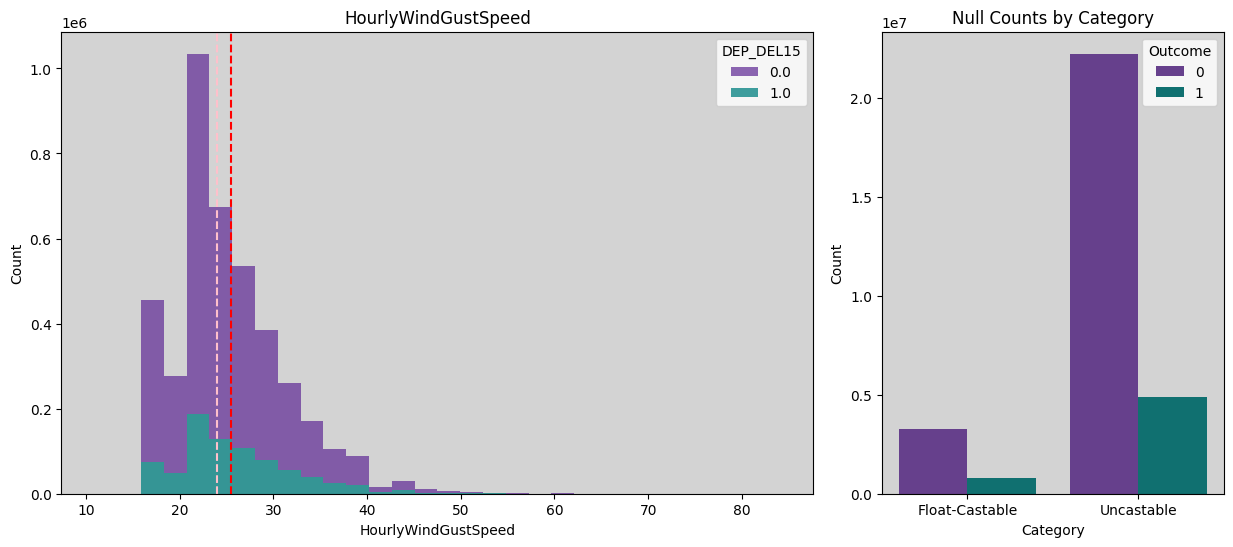

count,nulls_nans_count,string_nans_nulls_count,float_castable_count,uncastable_count,min_value,max_value,mean,std_dev
4157075,27516044,0,4157075,27516044,11.0,105.0,25.44,5.92


count,nulls_nans_count,string_nans_nulls_count,float_castable_count,uncastable_count,min_value,max_value,mean,std_dev
4157075,27516044,0,4157075,27516044,11.0,105.0,25.44,5.92


In [0]:
outcome_col = 'DEP_DEL15'
cols_to_summarize = [#'DELAYED_FLIGHTS_2_HOURS_PRIOR',
                     'HourlyWindGustSpeed'
                     ]

# summarize a *dataframe* using columns from above
summary_results = summarize_columns(OTPW_60M_gf, cols_to_summarize, outcome_col, sample_rate=1, to_show=True)
display(summary_results)

In [0]:
def get_mode(df, column_name):
    mode_value = df.groupBy(column_name).count().orderBy(F.desc('count')).limit(1).collect()[0][0]
    return mode_value

# handle column and do imputation
def summarize_column(df, column_name, outcome_col, sample_rate=1, to_show=True, seed=42):
    df = df if sample_rate==1 else df.sample(False, sample_rate, seed)
    # cast the specific column to float
    df_with_cast = df.withColumn(column_name, col(column_name).cast('float'))
    df_filtered = df_with_cast.filter(col(column_name).isNotNull())
    
    # determine flags for different conditions
    df_with_flags = df_with_cast.withColumn('is_null_or_nan', col(column_name).isNull() | isnan(col(column_name)))
    df_with_flags = df_with_flags.withColumn('is_string_nan_or_null', col(column_name).isin('nan', 'null'))
    df_with_flags = df_with_flags.withColumn('is_float_castable', ~col('is_null_or_nan') & ~col('is_string_nan_or_null'))

    agg_result = df_with_flags.agg(
        count(col(column_name)).alias('count'),
        sum(when(col('is_null_or_nan'), 1).otherwise(0)).alias('nulls_nans_count'),
        sum(when(col('is_string_nan_or_null'), 1).otherwise(0)).alias('string_nans_nulls_count'),
        sum(when(col('is_float_castable'), 1).otherwise(0)).alias('float_castable_count'),
        sum(when(~col('is_float_castable'), 1).otherwise(0)).alias('uncastable_count'), # Assuming is_float_castable is a boolean column
        min(col(column_name)).alias('min_value'),
        max(col(column_name)).alias('max_value'),
        round(avg(col(column_name)), 2).alias('mean'),
        round(stddev(col(column_name)), 2).alias('std_dev')
    )

    # summarization values
    col_mean = df_filtered.agg(mean(col(column_name)).alias('mean')).collect()[0]['mean']
    col_mode = get_mode(df_filtered, column_name)
    col_median = df_filtered.approxQuantile(column_name, [0.5], 0.01)[0]
    print(col_mean, col_mode, col_median)

    # plot histogram if to_show is True
    if to_show:
        display(agg_result.collect())

        pandas_df = df_with_cast.select([column_name, outcome_col]).toPandas()

        plt.figure(figsize=(15, 6))
        plt.subplot(1, 3, (1,2))

        sns.histplot(data=pandas_df, x=column_name,  hue=outcome_col, bins=30, palette=['rebeccapurple', 'teal'],
                            kde=False, linewidth=0.5, multiple="stack", element="step", edgecolor="none")

        col_mean = df_filtered.agg(mean(col(column_name)).alias('mean')).collect()[0]['mean']
        col_median = df_filtered.approxQuantile(column_name, [0.5], 0.01)[0]
        plt.axvline(x=col_mean,   color='red',    linestyle='--')
        plt.axvline(x=col_median, color='pink',   linestyle='--')
        plt.gca().set_facecolor('lightgray')
        plt.title(column_name)

        plt.subplot(1, 3, 3)

        res = df_with_flags.withColumn(f'{column_name}_0_null', when((col(column_name).isNull())  & (col(outcome_col) == 0), 1) .otherwise(0)) \
                           .withColumn(f'{column_name}_0_num',  when((~col(column_name).isNull()) & (col(outcome_col) == 0), 1) .otherwise(0)) \
                           .withColumn(f'{column_name}_1_null', when((col(column_name).isNull())  & (col(outcome_col) == 1), 1) .otherwise(0)) \
                           .withColumn(f'{column_name}_1_num',  when((~col(column_name).isNull()) & (col(outcome_col) == 1), 1) .otherwise(0))

        aggy = res.agg(
                        count(f'{column_name}_0_null').alias('count'),
                        sum(f'{column_name}_0_null').alias('0_null'),
                        sum(f'{column_name}_0_num').alias('0_num'),
                        sum(f'{column_name}_1_null').alias('1_null'),
                        sum(f'{column_name}_1_num').alias('1_num')
                ).collect()

        display(aggy)

        bar_data = pd.DataFrame({
            'Category': ['Float-Castable', 'Float-Castable', 'Uncastable', 'Uncastable'],
            'Outcome': [0, 1, 0, 1],
            'Count': [aggy[0][2], aggy[0][4], aggy[0][1], aggy[0][3]]
        })

        plt.gca().set_facecolor('lightgray')
        sns.barplot(x='Category', y='Count', hue='Outcome', data=bar_data, palette=['rebeccapurple', 'teal'])
        plt.title('Null Counts by Category')

        plt.show()

        # if comparator is not None and comparator in df_filtered.columns:
        #     df_filtered = df_filtered.withColumn(comparator, col(comparator).cast('float'))
        #     df_filtered = df_filtered.filter(col(comparator).isNotNull())

        #     # 2D correlation between column of interest vs this comparator
        #     pdf = df_filtered.select(column_name, comparator).toPandas()
        #     sns.scatterplot(x=column_name, y=comparator, data=pdf, alpha=0.03)
        #     plt.show()

    # return only the castable ones
    return agg_result

def summarize_columns(df, cols_to_summarize, outcome_col, sample_rate=.001, to_show=True, seed=42):
    # summary results dataframe
    result_df = None

    # loop through the columns
    for col_name in cols_to_summarize:
        agg_result = summarize_column(df, col_name, outcome_col, sample_rate=sample_rate, to_show=to_show, seed=42)
        result_df = result_df.union(agg_result) if result_df is not None else agg_result

    if to_show: 
        display(result_df)
    return result_df

In [0]:
OTPW_60M_gf.columns

['QUARTER',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_AIRLINE_ID',
 'OP_CARRIER',
 'TAIL_NUM',
 'OP_CARRIER_FL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN_AIRPORT_SEQ_ID',
 'ORIGIN_CITY_MARKET_ID',
 'ORIGIN',
 'ORIGIN_CITY_NAME',
 'ORIGIN_STATE_ABR',
 'ORIGIN_STATE_FIPS',
 'ORIGIN_STATE_NM',
 'ORIGIN_WAC',
 'DEST_AIRPORT_ID',
 'DEST_AIRPORT_SEQ_ID',
 'DEST_CITY_MARKET_ID',
 'DEST',
 'DEST_CITY_NAME',
 'DEST_STATE_ABR',
 'DEST_STATE_FIPS',
 'DEST_STATE_NM',
 'DEST_WAC',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'DEP_DELAY_NEW',
 'DEP_DEL15',
 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'ARR_DELAY_NEW',
 'ARR_DEL15',
 'ARR_DELAY_GROUP',
 'ARR_TIME_BLK',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'FLIGHTS',
 'DISTANCE',
 'DISTANCE_GROUP',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DEL

# Pagerank

In [0]:
def split_data(df):
    # train_test split
    #train_raw = df.filter(col('YEAR') != '2019') # null vulnerability; will collect garbage
    train_raw = df.filter(col('YEAR') <  '2019')
    test_raw  = df.filter(col('YEAR') == '2019')
    return train_raw, test_raw

def graph_from_data(df):
    # Prep Graph
    edges = (df.select('ORIGIN', 'DEST')
            .withColumnRenamed("ORIGIN", "src")
            .withColumnRenamed("DEST", "dst")).distinct()

    nodes = (edges.distinct().select('src')
            .union(edges.select('dst'))
            .distinct()
            .withColumnRenamed("src", "id"))

    return GraphFrame(nodes, edges)

def load_pagerank(loc=f"{blob_url}/pagerank"):
    return spark.read.parquet(loc)

def pageranker(df):

    df = df.repartition(100)
    origins_df = df.select("ORIGIN").distinct().withColumnRenamed("origin", "id")

    # Create a DataFrame with unique destinations and rename the 'destination' column to 'id'
    destinations_df = df.select("DEST").distinct().withColumnRenamed("destination", "id")
    vertices_df = origins_df.union(destinations_df).distinct()

    # Create edges DataFrame with 'src' and 'dst' columns representing the origin and destination of each flight
    edges_df = df.withColumnRenamed("origin", "src").withColumnRenamed("DEST", "dst")
    graph = GraphFrame(vertices_df, edges_df)
    results = graph.pageRank(resetProbability=0.15, maxIter=10)
    pagerank_scores = results.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False)

    return pagerank_scores

def add_graph_features_to_df(df, pagerank, graph):
    in_degrees = graph.inDegrees
    out_degrees = graph.outDegrees
    result = out_degrees.join(in_degrees, out_degrees.id == in_degrees.id, 'left').drop(in_degrees.id)

    graph_features = pagerank.join(result, pagerank.id == result.id, 'left').drop(result.id)
    df_gf_added = df.join(graph_features, df.ORIGIN == graph_features.id, 'left').drop(graph_features.id)
    return df_gf_added
    
# df.write.option("header", "true").parquet(f"{blob_url}/pipeline_train_js/")